In [1]:
#!pip install --root-user-action=ignore mlflow

# PyTorch в MLflow
Мы рассмотрим, как отслеживать эксперименты PyTorch и регистрировать модели PyTorch в MLflow.

## Регистрация экспериментов PyTorch в MLflow
### Авторегистрация экспериментов PyTorch


В отличие от других вариантов глубокого обучения, MLflow не имеет интеграции авторегистрации с PyTorch, поскольку собственный PyTorch требует написания пользовательских циклов обучения. Если вы хотите использовать авторегистрацию с PyTorch, используйте [Lightning](https://lightning.ai/docs/pytorch/stable/) для обучения своих моделей. Когда используется Lightning, вы можете включить авторегистрацию, вызвав mlflow.tensorflow.autolog() или mlflow.autolog(). Для получения более подробной информации обратитесь к Руководству разработчика MLflow Lightning.

###Ручная регистрация экспериментов PyTorch
Чтобы зарегистрировать эксперименты PyTorch, вы можете вставить регистрацию MLflow в цикл обучения PyTorch, который опирается на следующие API:

* `mlflow.log_metric() / mlflow.log_metrics()`: регистрировать метрики, такие как точность и потери во время обучения.

* `mlflow.log_param() / mlflow.log_params()`: регистрировать параметры, такие как скорость обучения и размер партии во время обучения.

* `mlflow.pytorch.log_model()`: сохранять модель PyTorch в MLflow, который обычно вызывается в конце обучения.

* `mlflow.log_artifact()`: регистрировать артефакты, такие как контрольные точки модели и графики во время обучения.

##Лучшие практики регистрации PyTorch в MLflow
Хотя регистрация экспериментов PyTorch идентична другим видам ручной регистрации, есть некоторые лучшие практики, которым мы рекомендуем следовать:

* Регистрируйте параметры модели и обучения с помощью `mlflow.log_params()` в начале цикла обучения, такие как скорость обучения, размер партии и т. д. `mlflow.log_params()` — это пакетная версия регистрации mlflow.log_param(), которая более эффективна, чем последняя.

* Регистрируйте архитектуру модели в начале обучения с помощью `mlflow.log_artifact()`. Вы можете использовать пакет torchinfo для получения сводки модели.

* Регистрируйте метрики обучения и проверки с помощью `mlflow.log_metric()` внутри цикла обучения, такие как потери и точность для задач классификации. Если у вас есть несколько метрик на шаг регистрации, вы можете использовать `mlflow.log_metrics()` для их совместной регистрации.

* Регистрируйте обученную/тонко настроенную модель в MLflow с помощью mlflow.`pytorch.log_model()` в конце обучения.

* Вы также можете регистрировать контрольные точки модели в MLflow через `mlflow.log_artifact()` во время обучения, если хотите сохранить статус среднего обучения.

Ниже приведен пример того, как регистрировать эксперименты PyTorch в MLflow:

In [2]:
#!pip install torchinfo torchmetrics

In [3]:
#!pip install mlflow --user

In [4]:
import mlflow
import torch

mlflow.set_tracking_uri("http://0.0.0.0:5000")

from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import Accuracy
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
mlflow.set_experiment("/mlflow-pytorch-quickstart")
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=64)

# Get cpu or gpu for training.
device = "cuda" if torch.cuda.is_available() else "cpu"


# Define the model.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


def train(dataloader, model, loss_fn, metrics_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        accuracy = metrics_fn(pred, y)

        # Backpropagation.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            mlflow.log_metric("loss", f"{loss:3f}", step=(batch // 100))
            mlflow.log_metric(
                "accuracy", f"{accuracy:3f}", step=(batch // 100)
            )
            print(
                f"loss: {loss:3f} accuracy: {accuracy:3f} [{current} / {len(dataloader)}]"
            )


epochs = 3
loss_fn = nn.CrossEntropyLoss()
metric_fn = Accuracy(task="multiclass", num_classes=10).to(device)
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": 1e-3,
        "batch_size": 64,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "SGD",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, metric_fn, optimizer)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

2024/11/23 08:11:19 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Epoch 1
-------------------------------
loss: 2.311261 accuracy: 0.015625 [0 / 938]
loss: 2.295909 accuracy: 0.140625 [100 / 938]
loss: 2.275414 accuracy: 0.203125 [200 / 938]
loss: 2.262123 accuracy: 0.312500 [300 / 938]
loss: 2.258143 accuracy: 0.328125 [400 / 938]
loss: 2.223572 accuracy: 0.437500 [500 / 938]
loss: 2.226520 accuracy: 0.343750 [600 / 938]
loss: 2.194479 accuracy: 0.421875 [700 / 938]
loss: 2.187186 accuracy: 0.359375 [800 / 938]
loss: 2.154227 accuracy: 0.500000 [900 / 938]
Epoch 2
-------------------------------
loss: 2.171573 accuracy: 0.312500 [0 / 938]
loss: 2.158104 accuracy: 0.437500 [100 / 938]
loss: 2.099045 accuracy: 0.531250 [200 / 938]
loss: 2.105289 accuracy: 0.531250 [300 / 938]
loss: 2.065887 accuracy: 0.468750 [400 / 938]
loss: 2.006943 accuracy: 0.515625 [500 / 938]
loss: 2.023956 accuracy: 0.468750 [600 / 938]
loss: 1.949291 accuracy: 0.562500 [700 / 938]
loss: 1.948865 accuracy: 0.500000 [800 / 938]
loss: 1.865940 accuracy: 0.640625 [900 / 938]
Epoc

2024/11/23 08:11:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


loss: 1.474947 accuracy: 0.687500 [900 / 938]


2024/11/23 08:11:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/23 08:11:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run able-calf-745 at: http://0.0.0.0:5000/#/experiments/210395392510849096/runs/14bef414c01943929f5c40f8439be4c1
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/210395392510849096


## Сохранение модели PyTorch в MLflow
Как мы уже упоминали в предыдущем разделе, вы можете сохранить модель PyTorch в MLflow с помощью mlflow.pytorch.log_model(). По умолчанию MLflow сохраняет вашу модель с суффиксом .pth. Пример кода сохранения и загрузки вашей модели PyTorch приведен ниже:

In [8]:
import mlflow
import numpy as np

from torch import nn


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork()

with mlflow.start_run() as run:
    mlflow.pytorch.log_model(model, "model")

logged_model = f"runs:/{run.info.run_id}/model"
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model.predict(np.random.uniform(size=[1, 28, 28]).astype(np.float32))

2024/11/23 08:11:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/23 08:11:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/23 08:11:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run beautiful-sponge-90 at: http://0.0.0.0:5000/#/experiments/210395392510849096/runs/ef59feda7132489f9916a2f3fac4b848
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/210395392510849096


array([[-0.01193345, -0.02684818, -0.05758462, -0.05763194, -0.02198429,
         0.04557112,  0.06205452,  0.09350055,  0.05397401, -0.09420492]],
      dtype=float32)

mlflow.pytorch.log_model() совместим с torch.jit.script(). Если у вас есть модель, скомпилированная с помощью jit, MLflow сохранит скомпилированный график.

## Подпись модели
Подпись модели — это описание входных и выходных данных модели. Подпись модели не является обязательной для загрузки модели, вы все равно можете загрузить модель и выполнить вывод, если знаете формат входных данных. Однако рекомендуется включать подпись для лучшего понимания модели. Чтобы добавить подпись модели в модель PyTorch, вы можете использовать API `mlflow.models.infer_signature()` или вручную задать подпись.

`mlflow.models.infer_signature()` принимает ваши входные данные и выходные данные модели для автоматического вывода подписи модели:

In [9]:
from mlflow.models import ModelSignature
import numpy as np

## Подпись модели
Подпись модели — это описание входных и выходных данных модели. Подпись модели не является обязательной для загрузки модели, вы все равно можете загрузить модель и выполнить вывод, если знаете формат входных данных. Однако рекомендуется включать подпись для лучшего понимания модели. Чтобы добавить подпись модели в модель PyTorch, вы можете использовать API mlflow.models.infer_signature() или вручную задать подпись.

mlflow.models.infer_signature() принимает ваши входные данные и выходные данные модели для автоматического вывода подписи модели:

In [11]:
import numpy as np
from mlflow.types import Schema, TensorSpec

input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 28, 28))])
output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 10))])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

После установки подписи вы можете включить ее при вызове `mlflow.pytorch.log_model()`:

In [12]:
import mlflow
import numpy as np

from torch import nn
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork()
input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 28, 28))])
output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 10))])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

with mlflow.start_run() as run:
    mlflow.pytorch.log_model(model, "model", signature=signature)

logged_model = f"runs:/{run.info.run_id}/model"
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model.predict(np.random.uniform(size=[1, 28, 28]).astype(np.float32))

2024/11/23 08:11:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/23 08:11:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


🏃 View run lyrical-goose-443 at: http://0.0.0.0:5000/#/experiments/210395392510849096/runs/c803e03063744342a999132db4e8ac89
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/210395392510849096


array([[-0.07943861,  0.11376345,  0.12030897,  0.06355351, -0.06325466,
        -0.01079218, -0.04142334,  0.02285686,  0.06447138, -0.07989229]],
      dtype=float32)

В пользовательском интерфейсе MLflow вы должны увидеть сигнатуру своей модели, как показано на снимке экрана ниже:

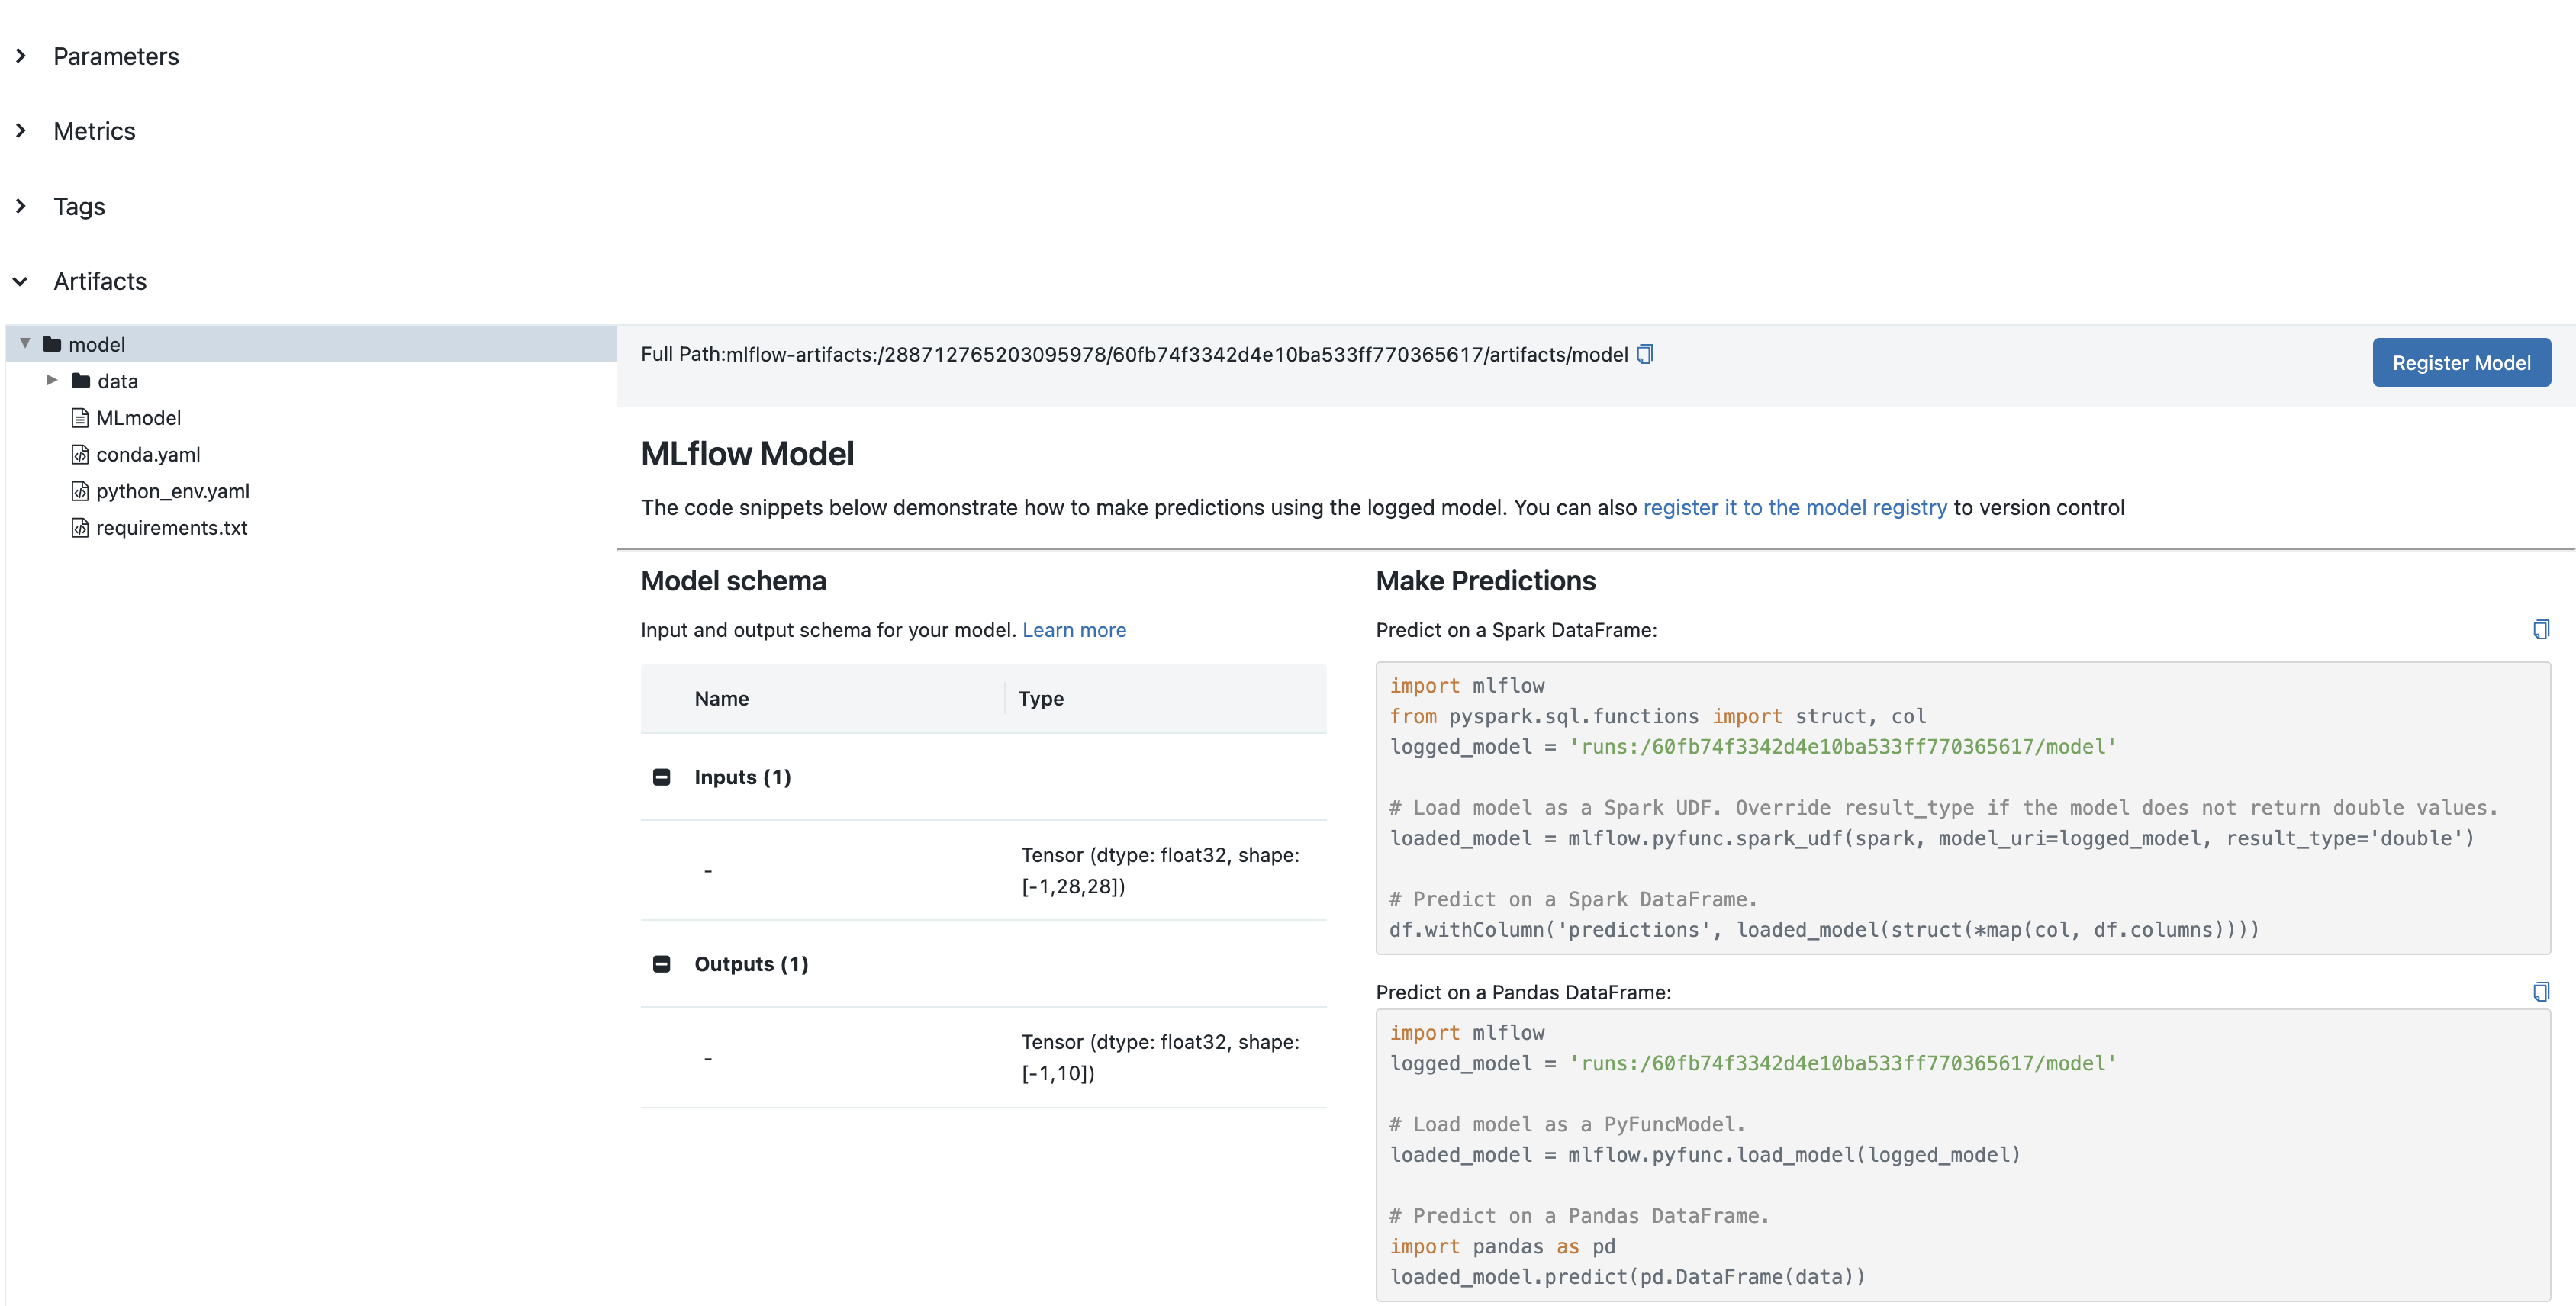

https://mlflow.org/docs/latest/deep-learning/pytorch/guide/index.html

https://mlflow.org/docs/latest/getting-started/index.html

In [18]:
!ls

MLOps.ipynb  data  mlruns  model_summary.txt  my_model.py


In [19]:
!ls mlruns

In [17]:
!rm -rf mlruns/models